In [ ]:
from google.colab import files
from os import listdir
import pandas as pd

In [ ]:
uploaded1 = files.upload()


Saving archive.zip to archive.zip


In [ ]:

!unzip archive.zip



Streaming output truncated to the last 5000 lines.
  inflating: training/training_setB/p115001.psv  
  inflating: training/training_setB/p115002.psv  
  inflating: training/training_setB/p115003.psv  
  inflating: training/training_setB/p115004.psv  
  inflating: training/training_setB/p115005.psv  
  inflating: training/training_setB/p115006.psv  
  inflating: training/training_setB/p115007.psv  
  inflating: training/training_setB/p115008.psv  
  inflating: training/training_setB/p115009.psv  
  inflating: training/training_setB/p115010.psv  
  inflating: training/training_setB/p115011.psv  
  inflating: training/training_setB/p115012.psv  
  inflating: training/training_setB/p115013.psv  
  inflating: training/training_setB/p115014.psv  
  inflating: training/training_setB/p115015.psv  
  inflating: training/training_setB/p115016.psv  
  inflating: training/training_setB/p115017.psv  
  inflating: training/training_setB/p115018.psv  
  inflating: training/training_setB/p115019.psv  

In [ ]:
!ls /content

archive.zip  sample_data  training


In [ ]:
!ls -U /content/training/training_setA/ | head -10


p016188.psv
p001196.psv
p010698.psv
p016904.psv
p017946.psv
p002530.psv
p009655.psv
p017199.psv
p015714.psv
p014853.psv


Format of a psv

In [ ]:
sampl = pd.read_csv('/content/training/training_setA/p000001.psv', sep='|')
sampl.head()

,HR,O2Sat,Temp,SBP,MAP,DBP,Resp,EtCO2,BaseExcess,HCO3,FiO2,pH,PaCO2,SaO2,AST,BUN,Alkalinephos,Calcium,Chloride,Creatinine,Bilirubin_direct,Glucose,Lactate,Magnesium,Phosphate,Potassium,Bilirubin_total,TroponinI,Hct,Hgb,PTT,WBC,Fibrinogen,Platelets,Age,Gender,Unit1,Unit2,HospAdmTime,ICULOS,SepsisLabel
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,1,0
1,97.0,95.0,NaN,98.0,75.33,NaN,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,2,0
2,89.0,99.0,NaN,122.0,86.00,NaN,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,3,0
3,90.0,95.0,NaN,NaN,NaN,NaN,30.0,NaN,24.0,NaN,NaN,7.36,100.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,4,0
4,103.0,88.5,NaN,122.0,91.33,NaN,24.5,NaN,NaN,NaN,0.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,83.14,0,NaN,NaN,-0.03,5,0


Merge Data
Train -Validation-Test Split
First approach for solving early prediction of sepsis is to ignore the temporal component in the data. So each record can be treated as a single entity not dependent on any other record. This assumption might be flawed but for establishing a baseline, we are taking this assumption

Train : 30K Patients Test : 5K Patients Validation : 5K Patients

In [ ]:
a_traincsv = listdir('/content/training/training_setA/')
b_traincsv = listdir('/content/training/training_setB/')


with open("train.psv","wb") as fout:

  for i,csv in enumerate(a_traincsv):
    
      # first file:
    if i == 0:
      with open('/content/training/training_setA/' + csv, "rb") as f:
          fout.write(f.read())
      # now the rest:    
    with open('/content/training/training_setA/' + csv, "rb") as f:
      next(f) # skip the header
      fout.write(f.read())
      
  for i,csv in enumerate(b_traincsv):
    if i <10000:
      with open('/content/training/training_setB/' + csv, "rb") as f:
        next(f) # skip the header
        fout.write(f.read())

In [ ]:
train = pd.read_csv('/content/train.psv', sep ='|')
train.shape

(1171137, 41)

In [ ]:
with open("validation.psv","wb") as fout:

  for i,csv in enumerate(b_traincsv):
    
    if i >=10000 and i <15000:

        # first file:
      if i == 10000:
        with open('/content/training/training_setB/' + csv, "rb") as f:
            fout.write(f.read())
        # now the rest:    
      with open('/content/training/training_setB/' + csv, "rb") as f:
        next(f) # skip the header
        fout.write(f.read())


In [ ]:
validation = pd.read_csv('/content/validation.psv', sep ='|')
validation.shape

(193443, 41)

In [ ]:
with open("test.psv","wb") as fout:

  for i,csv in enumerate(b_traincsv):
    
    if i >=15000:

        # first file:
      if i == 15000:
        with open('/content/training/training_setB/' + csv, "rb") as f:
            fout.write(f.read())
        # now the rest:    
      with open('/content/training/training_setB/' + csv, "rb") as f:
        next(f) # skip the header
        fout.write(f.read())

In [ ]:
test = pd.read_csv('/content/test.psv', sep ='|')
test.shape

(187762, 41)

In [ ]:
train.columns


Index(['HR', 'O2Sat', 'Temp', 'SBP', 'MAP', 'DBP', 'Resp', 'EtCO2',
       'BaseExcess', 'HCO3', 'FiO2', 'pH', 'PaCO2', 'SaO2', 'AST', 'BUN',
       'Alkalinephos', 'Calcium', 'Chloride', 'Creatinine', 'Bilirubin_direct',
       'Glucose', 'Lactate', 'Magnesium', 'Phosphate', 'Potassium',
       'Bilirubin_total', 'TroponinI', 'Hct', 'Hgb', 'PTT', 'WBC',
       'Fibrinogen', 'Platelets', 'Age', 'Gender', 'Unit1', 'Unit2',
       'HospAdmTime', 'ICULOS', 'SepsisLabel'],
      dtype='object')

In [ ]:
train['SepsisLabel'].value_counts()


0    1148575
1      22562
Name: SepsisLabel, dtype: int64

In [ ]:
from google.colab import files
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn_pandas import CategoricalImputer
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams

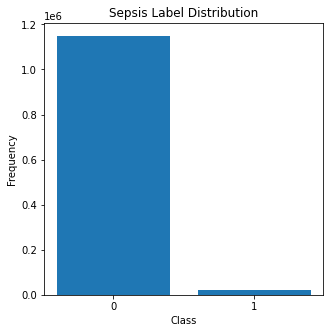

In [ ]:
rcParams['figure.figsize'] = 5, 5

plt.bar(train['SepsisLabel'].value_counts().index,
        train['SepsisLabel'].value_counts())
plt.xticks([0,1])
plt.xlabel('Class')
plt.title('Sepsis Label Distribution')
_ = plt.ylabel('Frequency')

Check For null in Features/ Independent variables

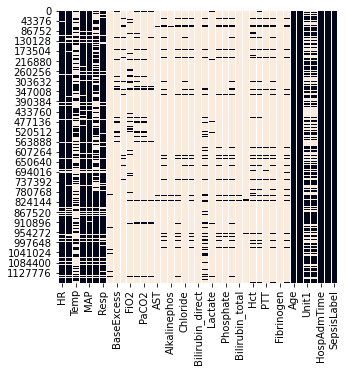

In [ ]:
sns.heatmap(train.isnull(), cbar=False)


In [ ]:
missing = (train.isnull().sum() / train.shape[0]) * 100
missing

HR                   9.164427
O2Sat               12.716189
Temp                66.193793
SBP                 14.798781
MAP                 11.698802
DBP                 37.015225
Resp                13.394419
EtCO2               97.477579
BaseExcess          92.886742
HCO3                94.504742
FiO2                89.675503
pH                  91.515766
PaCO2               93.334768
SaO2                96.026938
AST                 98.414959
BUN                 92.695218
Alkalinephos        98.436733
Calcium             94.405608
Chloride            94.173952
Creatinine          93.717046
Bilirubin_direct    99.818382
Glucose             84.523502
Lactate             97.049875
Magnesium           93.183803
Phosphate           95.631852
Potassium           90.147182
Bilirubin_total     98.592820
TroponinI           99.311524
Hct                 90.151451
Hgb                 92.121588
PTT                 96.409301
WBC                 93.221459
Fibrinogen          99.299313
Platelets 

Text(0.5, 1.0, 'Percentage of missing data in each feature')

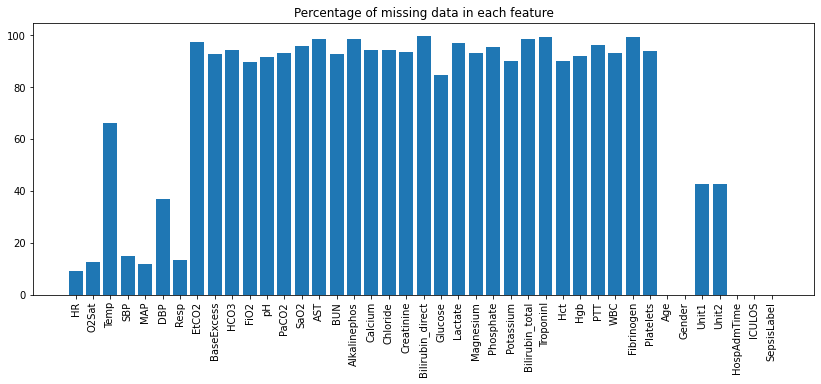

In [ ]:
rcParams['figure.figsize'] = 14, 5
_ = plt.bar(missing.index, missing)
_ = plt.xticks(missing.index, rotation=90)

plt.title("Percentage of missing data in each feature")


In [ ]:
selected_cols = list(missing[missing < 90].index)
selected_cols

['HR',
 'O2Sat',
 'Temp',
 'SBP',
 'MAP',
 'DBP',
 'Resp',
 'FiO2',
 'Glucose',
 'Age',
 'Gender',
 'Unit1',
 'Unit2',
 'HospAdmTime',
 'ICULOS',
 'SepsisLabel']

Feature Engineering



Heart rate for a healthy adult is between 60 and 100. For a healthy infant it is between 70 and 190. Creating a new feature custom_hr , which is categorical variable having three values Normal, Abnormal and Missing

In [ ]:
def feature_engineer_hr(train):
    train.loc[(train['HR'] >= 100) & (train['Age'] >= 10 ),
            'custom_hr'] = 'abnormal'
    train.loc[(train['HR'] < 100) & (train['HR'] > 60) & (train['Age'] >= 10 ),
            'custom_hr'] = 'normal'
    train.loc[(train['HR'] >= 70) & (train['HR'] < 190) & (train['Age'] < 10 ),
            'custom_hr'] = 'normal'
    train.loc[((train['HR'] < 70) | (train['HR'] >= 190)) & (train['Age'] < 10 ),
            'custom_hr'] = 'abnormal'
    train['custom_hr'].fillna('Missing', inplace=True)
    return train

In [ ]:
def feature_engineer_temp(train):
    train.loc[(train['Temp'] >= 36.4) & (train['Temp'] < 37.6), 
            'custom_temp'] = 'normal'
    train.loc[(train['Temp'] < 36.4) | (train['Temp'] >= 37.6), 
            'custom_temp'] = 'abnormal'

    train['custom_temp'].fillna('Missing', inplace=True)
    return train
    


In [ ]:
def featuer_engineer_age(train):
    train.loc[train['Age'] >=65, 'custom_age'] = 'old'
    train.loc[train['Age'] <1, 'custom_age'] = 'infant'
    train.loc[(train['Age'] >=1) & (train['Age'] <65), 
            'custom_age'] = 'child/adult'
    return train

In [ ]:
def feature_engineer_o2stat(train):
    train.loc[(train['O2Sat'] >= 90) & (train['O2Sat'] < 100), 
            'custom_o2stat'] = 'normal'
    train.loc[(train['O2Sat'] < 90) & (train['O2Sat'] >= 0), 
            'custom_o2stat'] = 'abnormal'

    train['custom_o2stat'].fillna('Missing', inplace=True)
    return train

In [ ]:
def feature_engineer_blood_pressure(train):
    train.loc[(train['SBP'] <90) & (train['DBP'] <60), 'custom_bp'] = 'low'

    train.loc[(train['SBP'].between(90,120, inclusive=True)) & 
            (train['DBP'].between(60,80, inclusive=True)), 
            'custom_bp'] = 'normal'


    train.loc[(train['SBP'].between(120,140, inclusive=True)) & 
            (train['DBP'].between(80,90, inclusive=True)), 
            'custom_bp'] = 'elevated'


    train.loc[(train['SBP'] > 140 ) & 
            (train['DBP'] > 90 ), 'custom_bp'] = 'high'

    train['custom_bp'].fillna('Missing', inplace=True)
    return train

In [ ]:
def feature_engineer_resp_rate(train):
    train.loc[(train['Resp'].between(30,60)) & (train['Age'] <1), 
            'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 30) | (train['Resp'] > 60)) & 
             (train['Age'] <1) ,'custom_resp'] = 'abnormal'


    train.loc[(train['Resp'].between(24,40)) & (train['Age'].between(1,3)), 
            'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 24) | (train['Resp'] > 40)) & 
             (train['Age'].between(1,3)) ,'custom_resp'] = 'abnormal'


    train.loc[(train['Resp'].between(22,34)) & (train['Age'].between(3,6)), 
            'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 22) | (train['Resp'] > 34)) & 
             (train['Age'].between(3,6)) ,'custom_resp'] = 'abnormal'


    train.loc[(train['Resp'].between(18,30)) & (train['Age'].between(6,12)), 
            'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 18) | (train['Resp'] > 30)) & 
             (train['Age'].between(6,12)) ,'custom_resp'] = 'abnormal'


    train.loc[(train['Resp'].between(12,20)) & (train['Age'] >12), 
            'custom_resp'] = 'normal'
    train.loc[((train['Resp'] < 12) | (train['Resp'] > 20)) & (train['Age'] >12),
            'custom_resp'] = 'abnormal'

    train['custom_resp'].fillna('Missing', inplace=True)


    return train
  

In [ ]:
train = featuer_engineer_age(train)
train = feature_engineer_blood_pressure(train)
train = feature_engineer_hr(train)
train = feature_engineer_o2stat(train)
train = feature_engineer_temp(train)
train = feature_engineer_resp_rate(train)



validation = featuer_engineer_age(validation)
validation = feature_engineer_blood_pressure(validation)
validation = feature_engineer_hr(validation)
validation = feature_engineer_o2stat(validation)
validation = feature_engineer_temp(validation)
validation = feature_engineer_resp_rate(validation)




In [ ]:
filtered_columns = ['Gender', 'custom_hr', 'custom_temp','custom_age', 
                    'custom_o2stat', 'custom_bp','custom_resp' ,'ICULOS', 
                    'HospAdmTime']

X_train  = train[filtered_columns]
y_train = train['SepsisLabel']

X_val  = validation[filtered_columns]
y_val = validation['SepsisLabel']

In [ ]:
categorical = X_train.dtypes == object

categorical['Gender'] = True

Defining the Pipeline

In [ ]:
cat_pipeline = make_pipeline( OneHotEncoder(handle_unknown="ignore"))
cont_scale_pipeline = make_pipeline(SimpleImputer(strategy = "median"),
                                    StandardScaler())

preprocess_trans_scale = make_column_transformer((cont_scale_pipeline, 
                                                  ~categorical), 
                                                 (cat_pipeline, categorical))


AutoEncoders

## Filter data on class labels (0 and 1)


In [ ]:
train_0 = train[train['SepsisLabel'] ==0]
train_1 = train[train['SepsisLabel'] ==1]

filtered_columns = ['Gender', 'custom_hr', 'custom_temp','custom_age', 
                    'custom_o2stat', 'custom_bp','custom_resp' ,'ICULOS', 
                    'HospAdmTime']

X_train_0  = train_0[filtered_columns]
y_train_0 = train_0['SepsisLabel']

## Fit/Transform data 

In [ ]:
X_train_0_transformed = preprocess_trans_scale.fit_transform(X_train_0)

X_val_transformed = preprocess_trans_scale.transform(X_val)

Defining the AutoEncoder Architecture

In [ ]:
from keras.layers import Dense, Input
from keras.models import Model, Sequential
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras import regularizers
nb_epoch = 20
batch_size = 128
input_dim = X_train_0_transformed.shape[1] #num of predictor variables, 
encoding_dim = 32
hidden_dim = int(encoding_dim / 2)
learning_rate = 1e-3

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="relu", 
                activity_regularizer=regularizers.l1(learning_rate))(input_layer)
encoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(hidden_dim, activation="relu")(encoder)
decoder = Dense(encoding_dim, activation="relu")(decoder)
decoder = Dense(input_dim, activation="linear")(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
autoencoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                768       
_________________________________________________________________
dense_11 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_12 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_13 (Dense)             (None, 32)                544       
_________________________________________________________________
dense_14 (Dense)             (None, 23)                759       
Total params: 2,871
Trainable params: 2,871
Non-trainable params: 0
_________________________________________________________

Training AutoEncoder

In [ ]:
autoencoder.compile(metrics=['accuracy'],
                    loss='mean_squared_error',
                    optimizer='adam')
cp = ModelCheckpoint(filepath="autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=25)
tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)
history = autoencoder.fit(X_train_0_transformed, X_train_0_transformed,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    verbose=1,
                    callbacks=[cp, tb, es]).history

Epoch 1/20
8974/8974 [==============================] - 18s 2ms/step - loss: 0.0426 - accuracy: 0.1753
Epoch 2/20
8974/8974 [==============================] - 16s 2ms/step - loss: 0.0023 - accuracy: 0.1638
Epoch 3/20
8974/8974 [==============================] - 16s 2ms/step - loss: 0.0016 - accuracy: 0.1727
Epoch 4/20
8974/8974 [==============================] - 16s 2ms/step - loss: 0.0013 - accuracy: 0.1717
Epoch 5/20
8974/8974 [==============================] - 17s 2ms/step - loss: 0.0012 - accuracy: 0.1721
Epoch 6/20
8974/8974 [==============================] - 16s 2ms/step - loss: 0.0011 - accuracy: 0.1702
Epoch 7/20
8974/8974 [==============================] - 16s 2ms/step - loss: 0.0011 - accuracy: 0.1747
Epoch 8/20
8974/8974 [==============================] - 17s 2ms/step - loss: 0.0011 - accuracy: 0.1616
Epoch 9/20
8974/8974 [==============================] - 16s 2ms/step - loss: 0.0011 - accuracy: 0.1739
Epoch 10/20
8974/8974 [==============================] - 17s 2ms/step - l

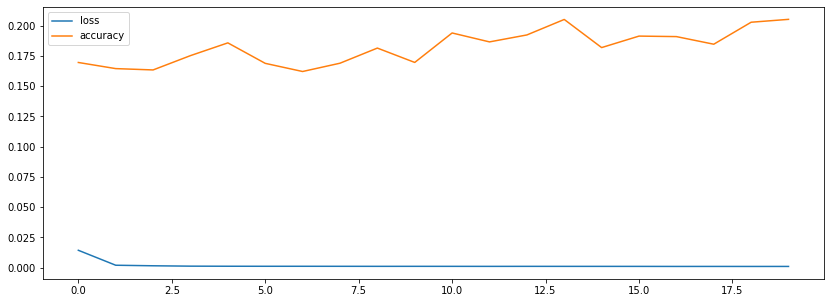

In [ ]:
pd.DataFrame(history).plot()


In [ ]:
from sklearn.metrics import precision_recall_curve

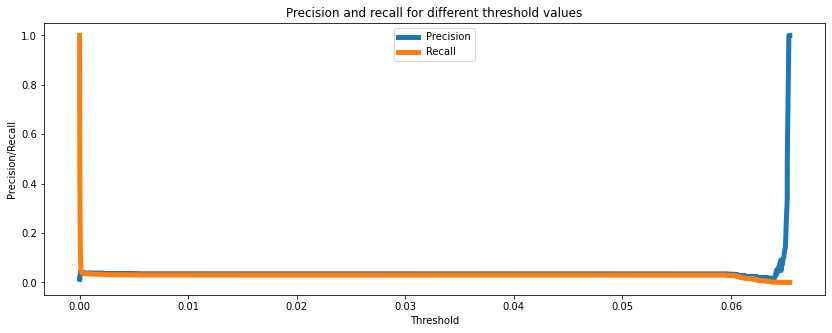

In [ ]:
valid_x_predictions = autoencoder.predict(X_val_transformed)
mse = np.mean(np.power(X_val_transformed - valid_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_val})
precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label="Precision",linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label="Recall",linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

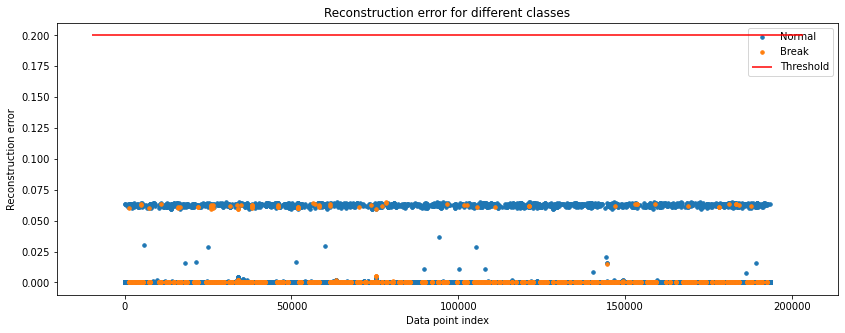

In [ ]:
valid_x_predictions = autoencoder.predict(X_val_transformed)
mse = np.mean(np.power(X_val_transformed - valid_x_predictions, 2), axis=1)
error_df_test = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_val})
error_df_test = error_df_test.reset_index()
threshold_fixed = 0.2
groups = error_df_test.groupby('True_class')
fig, ax = plt.subplots()
for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();


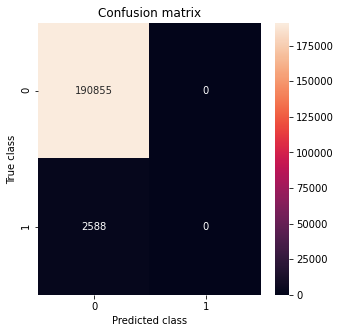

In [ ]:
LABELS = ["Normal","Sepsis"]

pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()